MAE : 8.414380913499341
RMSE: 10.82657711350666
R2  : 0.8256849229537493


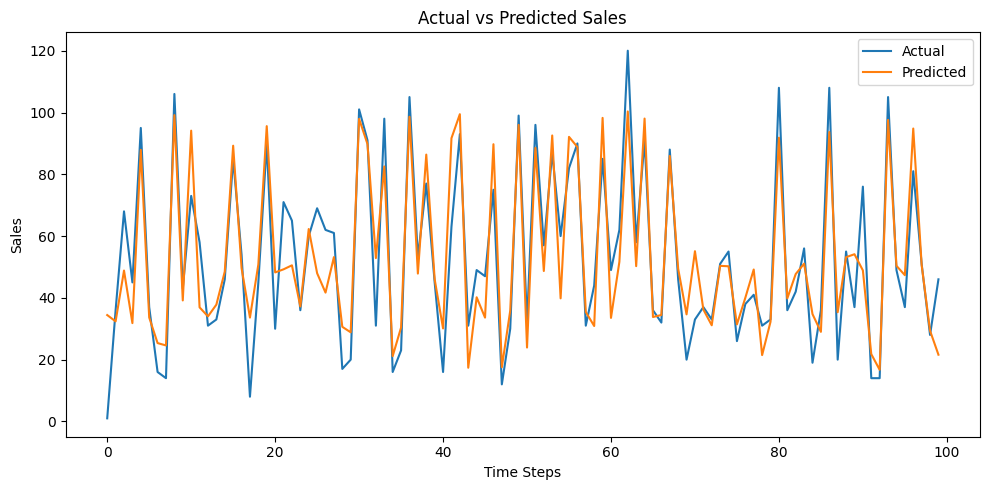

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load data
df = pd.read_csv("market_sales.csv")
df['date'] = pd.to_datetime(df['date'])

# Sort by product and date
df = df.sort_values(['product_id', 'date'])

# Create time features
df['year']       = df['date'].dt.year
df['month']      = df['date'].dt.month
df['day']        = df['date'].dt.day
df['weekday']    = df['date'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['month_sin']  = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos']  = np.cos(2 * np.pi * df['month'] / 12)

# Create lag features per product
df['lag_1']  = df.groupby('product_id')['sales'].shift(1)
df['lag_7']  = df.groupby('product_id')['sales'].shift(7)
df['lag_14'] = df.groupby('product_id')['sales'].shift(14)

# Drop date column
df.drop('date', axis=1, inplace=True)

# One-hot encode product_id
df = pd.get_dummies(df, columns=['product_id'], drop_first=True)

# Fill missing values
df.fillna(df.mean(numeric_only=True), inplace=True)

# Split into features and target
X = df.drop('sales', axis=1)
y = df['sales']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest model
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:150], label="Actual", linewidth=1.5)
plt.plot(y_pred[:150], label="Predicted", linewidth=1.5)
plt.title("Actual vs Predicted Sales")
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()
